**OBJECTIVE:** Exploratory analysis of the movelets produced

**AUTHOR:** [@jonjoncardoso](https://github.com/jonjoncardoso)

**CREATED AT:** 22 September 2022

In [151]:
import os
import json

import numpy as np
import pandas as pd
import matplotlib

from mizani.formatters import percent_format

%config InlineBackend.figure_formats = ['svg']
from plotnine import *

from tqdm.notebook import tqdm

# Read data

1. Download the zipfile containing HIPER-PIVOTS results (get the link from [@jonjoncardoso](https://github.com/jonjoncardoso))
2. Place the zip file under the `/data` folder
3. Extract all
3. Modify the variables below

In [39]:
zip_filename = "HIPER-PIVOTS_Log_Basometro_4Y_specific_hp_LSP_ED"
POLITICAL_PARTIES = os.listdir(os.path.join("../data", zip_filename))

In [91]:
len(POLITICAL_PARTIES)

33

# Results: understanding the data structure

In [120]:
def read_movelets(political_party, zip_filename=zip_filename):
    with open(f"../data/{zip_filename}/{political_party}/moveletsOnTrain.json", encoding="utf-8") as f:
        data = json.load(f)
    return data

data = read_movelets("Patriota")

In [121]:
len(data["movelets"])

745

In [123]:
data["movelets"][0].keys()

dict_keys(['start', 'end', 'trajectory', 'label', 'featuresNames', 'points_with_only_the_used_features', 'pointFeatures', 'splitpoints', 'distances', 'data', 'quality'])

In [116]:
data["movelets"][1]["featuresNames"]

{'1': 'voto',
 '2': 'orientacaoGoverno',
 '3': 'anoProposicao',
 '4': 'anoVotacao',
 '5': 'tipoProposicao',
 '8': 'data'}

In [113]:
data["movelets"][1]["points_with_only_the_used_features"]

[{'data': 'Jun 19, 2013, 12:33:00 PM', 'orientacaoGoverno': 'Liberado'}]

In [110]:
data["movelets"][1]["pointFeatures"]

[1, 2, 3, 4, 5, 8]

In [122]:
data["movelets"][1]["quality"]

{'size': 1.0,
 'start': 98.0,
 'tid': 1727.0,
 'quality': 0.012997562956945572,
 'dimensions': 6.0}

I am not sure what `trajectory` represents here. There are only 2 unique values:

In [125]:
pd.Series([x["trajectory"] for x in data["movelets"]]).value_counts()

2889    644
1727    101
dtype: int64

**Questions**

- What does `data["movelets"][x]["trajectory"]` represents?

# Q: Which parties were easier to fit, i.e. returned highest quality metrics?

In [174]:
def parse_quality_df(political_party):
    data = read_movelets(political_party)
    tmp_df = pd.concat([pd.DataFrame(dict(**x["quality"], **x["points_with_only_the_used_features"][0], political_party=political_party), index=[0]) 
                        for x in data["movelets"]])
    return tmp_df

df = pd.concat([parse_quality_df(party) for party in tqdm(POLITICAL_PARTIES)])

  0%|          | 0/33 [00:00<?, ?it/s]

In [176]:
df.head()

,size,start,tid,quality,dimensions,UF,tipoProposicao,data,anoVotacao,anoProposicao,orientacaoGoverno,political_party,voto,idVotacao,governo
0,1.0,434.0,1229.0,0.129032,6.0,RJ,PL,"Feb 24, 2010, 2:17:00 PM",2010.0,2009.0,Obstrução,Avante,NaN,NaN,NaN
0,1.0,57.0,1229.0,0.090909,4.0,RJ,NaN,NaN,NaN,2007.0,Obstrução,Avante,Não,NaN,NaN
0,1.0,50.0,1229.0,0.081633,4.0,RJ,NaN,NaN,NaN,2004.0,Obstrução,Avante,Não,NaN,NaN
0,1.0,473.0,1229.0,0.068966,6.0,RJ,MPV,"Nov 9, 2010, 6:55:00 PM",NaN,2010.0,Sim,Avante,Sim,NaN,NaN
0,1.0,464.0,1229.0,0.067797,7.0,RJ,PL,"May 12, 2010, 8:03:00 PM",2010.0,2007.0,Sim,Avante,Sim,NaN,NaN


In [177]:
plot_df = df.copy()

# Re-order
plot_df["political_party"] = pd.Categorical(plot_df["political_party"], categories=plot_df.groupby(["political_party"])["quality"].mean().sort_values(ascending=False).index.tolist())

In [178]:
g = (
    ggplot(plot_df, aes(x="political_party", y="quality", fill="political_party")) +
    
    geom_boxplot() +
    
    scale_fill_discrete(guide=False) + 
    scale_y_continuous(name="Quality", labels=percent_format()) +
    scale_x_discrete(name="") +
    
    ggtitle("Distribution of quality metric per political party") +
    
    theme_bw() +
    theme(
        axis_title_x = element_text(size=15, margin = dict(t = 10, r = 0 , b = 0, l = 0)),
        axis_title_y = element_text(size=15, margin = dict(t = 0,  r = 10, b = 0, l = 0)),
        axis_text_x = element_text(size=13, angle=90),
        axis_text_y = element_text(size=13),
        title = element_text(size=18),
        panel_grid_minor = element_blank(),
        figure_size=(15, 6))
    
)

g

<ggplot: (146558916801)>

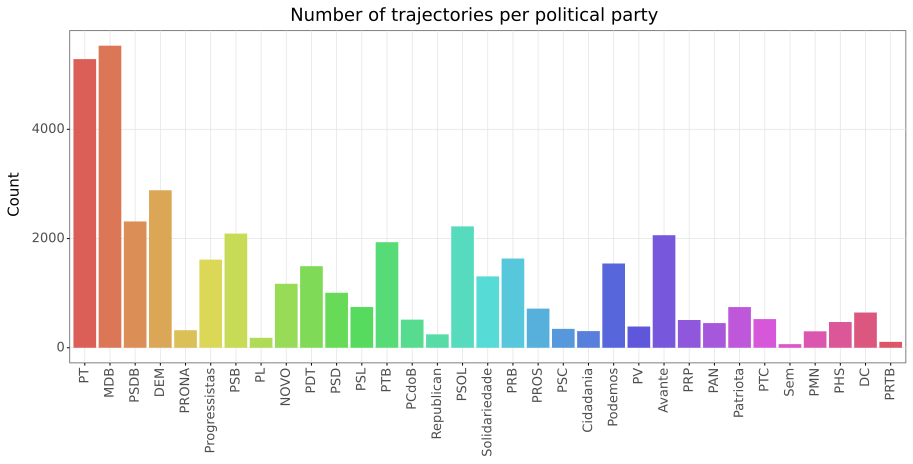

<ggplot: (146574088364)>

In [169]:
plot_df2 = plot_df.groupby(["political_party"]).apply(lambda x: pd.Series({"count": len(x)})).reset_index()

g = (
    ggplot(plot_df2, aes(x="political_party", y="count", fill="political_party")) +
    
    geom_col() +
    
    scale_fill_discrete(guide=False) + 
    scale_y_continuous(name="Count") +
    scale_x_discrete(name="") +
    
    ggtitle("Number of trajectories per political party") +
    
    theme_bw() +
    theme(
        axis_title_x = element_text(size=15, margin = dict(t = 10, r = 0 , b = 0, l = 0)),
        axis_title_y = element_text(size=15, margin = dict(t = 0,  r = 10, b = 0, l = 0)),
        axis_text_x = element_text(size=13, angle=90),
        axis_text_y = element_text(size=13),
        title = element_text(size=18),
        panel_grid_minor = element_blank(),
        figure_size=(15, 6))
    
)

g

# Q: (Edge Cases) What are the movelets that are so _perfectly_ associated with a particular party?

Here I am interested in the cases where $quality > 85\%$. What makes these trajectories so unique?

In [179]:
df[df["quality"] > 0.85]

,size,start,tid,quality,dimensions,UF,tipoProposicao,data,anoVotacao,anoProposicao,orientacaoGoverno,political_party,voto,idVotacao,governo
0,1.0,567.0,2581.0,0.909091,6.0,NaN,PL,NaN,2021.0,2019.0,Sim,NOVO,Não,1-7-2021.12.04.17120,NaN
0,1.0,8.0,28.0,1.000000,4.0,SP,NaN,NaN,NaN,NaN,Sim,PRONA,Não,2-4-2003.19.18.751,NaN


# Q: How "unique" are the trajectories identified in a particular party?

## Party: `PT`

First, which features were more commonly selected to identify this party?

In [193]:
aux_df = df[df["political_party"] == "PT"].copy()

aux_df.drop(columns=["size", "start", "tid", "political_party", "quality", "dimensions"], inplace=True)

aux_df.apply(lambda x: pd.Series({"pctg": 100 * ((len(aux_df) - x.isnull().sum())/len(aux_df))}), axis=0)

,UF,tipoProposicao,data,anoVotacao,anoProposicao,orientacaoGoverno,voto,idVotacao,governo
pctg,0.0,22.777147,98.448733,55.353765,63.715475,65.247824,65.323496,0.0,0.0


## Party: `MDB`

In [192]:
aux_df = df[df["political_party"] == "MDB"].copy()

aux_df.drop(columns=["size", "start", "tid", "political_party", "quality", "dimensions"], inplace=True)

aux_df.apply(lambda x: pd.Series({"pctg": 100 * ((len(aux_df) - x.isnull().sum())/len(aux_df))}), axis=0)

,UF,tipoProposicao,data,anoVotacao,anoProposicao,orientacaoGoverno,voto,idVotacao,governo
pctg,0.0,29.555315,97.830803,60.285611,69.956616,80.097614,87.147505,0.0,0.0


## Party: `PSDB`

In [194]:
aux_df = df[df["political_party"] == "PSDB"].copy()

aux_df.drop(columns=["size", "start", "tid", "political_party", "quality", "dimensions"], inplace=True)

aux_df.apply(lambda x: pd.Series({"pctg": 100 * ((len(aux_df) - x.isnull().sum())/len(aux_df))}), axis=0)

,UF,tipoProposicao,data,anoVotacao,anoProposicao,orientacaoGoverno,voto,idVotacao,governo
pctg,14.613057,21.919585,94.552529,43.709468,69.433636,78.599222,67.617812,0.0,0.0
